## План

1. EDA
2. Дизайн А/Б-теста
3. Ответы на вопросы

## EDA
---

In [358]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from urllib.parse import urlencode

In [359]:
def get_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [360]:
df = pd.read_csv(get_download_url('https://disk.yandex.ru/d/gdXR2lcq7vVutg'),
                 sep=';',
                 parse_dates=['registration_date', 'activation_date'],
                 dayfirst=True)

In [361]:
df.head()

,registration_date,activation_date,merchant_id,type,ind_frod
0,2023-12-16,2023-12-24,1,IE,0.0
1,2023-09-05,2023-09-08,2,IE,0.0
2,2023-04-16,2023-04-22,3,IE,0.0
3,2023-12-23,2023-12-24,4,IE,0.0
4,2023-01-28,NaT,5,IE,0.0


In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   registration_date  35000 non-null  datetime64[ns]
 1   activation_date    20300 non-null  datetime64[ns]
 2   merchant_id        35000 non-null  int64         
 3   type               35000 non-null  object        
 4   ind_frod           34300 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 1.3+ MB


---
Всего в датафрейме 35000 строк. Видим, что у `ind_frod` есть 700 пропусков, почистим это поле сразу от пропусков и выбросов (оставляем только 1 и 0)



In [363]:
df = df.query(' 0 <= ind_frod <= 1')

---
Посмотрим на уникальные значения в данных


In [364]:
df.nunique()

registration_date      365
activation_date        380
merchant_id          34300
type                     2
ind_frod                 2
dtype: int64


Видим что все `merchant_id` уникальные

---
Теперь поработаем с датами

---

In [365]:
# Смотрим, за какой временной период у нас есть данные по регистрации
print(df.registration_date.min(), df.registration_date.max())

1970-01-01 00:00:00 2023-12-31 00:00:00


---
Видим что даты регистрации начинаются с 1970-01-01 - это равняется 0 в Unix-формате.

Скорее всего произошел баг и дата регистрации занулилась, либо это были тестовые регистрации 

посмотрим вторую минимальную дату и кол-во таких ошибок

In [366]:
print(sorted(df.registration_date.unique())[0:2])
print("-----")
print((df.registration_date == '1970-01-01').sum())
print("-----")
print(df.query('registration_date == @pd.Timestamp("01.01.1970") and activation_date.notnull()').shape[0])

[Timestamp('1970-01-01 00:00:00'), Timestamp('2023-01-02 00:00:00')]
-----
173
-----
85


---
В целом таких наблюдений немного, однако при этом 85 из 175 разарегистрированных продавцов ставли активными 

Вторая минимальная дата 2023-01-02, можно предположить, что ошибка была при записи даты регистрации 1 января 2023

У нас есть 2 варианта: или удалить эти данные или перезаписать как 2023-01-01

Так как таких наблюдений не так много можем удалить их

In [367]:
df = df.query("registration_date != @pd.Timestamp('1970-01-01')")

---
Также стоит проверить наличие ошибок в записях даты активации, есть ли записи, где `activation_date` < `registration_date`?



In [368]:
df.query('activation_date < registration_date').shape[0]

19

In [369]:
# Такие записи есть, их всего 19 можем смело исключить их
df = df.query('activation_date >= registration_date or activation_date.isnull()')

# Смотрим, за какой временной период у нас есть данные по активации
print(df.activation_date.min(), df.activation_date.max())

2023-01-03 00:00:00 2024-08-30 00:00:00


In [370]:
# Посмотрим на наблюдения с датой активации в 2024 году
df.query('activation_date > "31.12.2023"').sort_values('activation_date', ascending=False).head()

,registration_date,activation_date,merchant_id,type,ind_frod
34890,2023-08-23,2024-08-30,34891,LLC,0.0
29939,2023-12-31,2024-01-11,29940,LLC,1.0
23723,2023-12-31,2024-01-11,23724,IE,0.0
23813,2023-12-30,2024-01-10,23814,IE,0.0
9272,2023-12-31,2024-01-10,9273,IE,0.0


In [371]:
# видим, что есть наблюдение где активация произошла позже, чем через год, уддалим
df.drop(34890, inplace=True)

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34107 entries, 0 to 34999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   registration_date  34107 non-null  datetime64[ns]
 1   activation_date    19796 non-null  datetime64[ns]
 2   merchant_id        34107 non-null  int64         
 3   type               34107 non-null  object        
 4   ind_frod           34107 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


---
**Теперь данные чистые и полные, можем исследовать**

---

Так как активация означет, что пользователь **"прошел все этапы регистрации и может продавать товар"** вытащим пользователей которые прошли регистрацию в отдельный dataframe

In [373]:
activ_df = df.query('activation_date.notnull()')

---
Посмотрим на долю юзеров которые активировались после регистрации



In [374]:
print(activ_df.shape[0]/ df.shape[0] * 100)

58.04087137537749



До активации доходят ≈ 58% продавцов - это наша **конверсия в активацию**, в дизайне экспереимента можем взять ее в качестве контр метрики

---

Исследуем данные по `ind_drod`

In [375]:
# Посмотрим на %мошенников среди всех активированных пользователей
round(activ_df.query('ind_frod == 1').shape[0] / activ_df.shape[0] * 100, 4)

8.0774

In [376]:
# теперь посмотрим на долю мошенников в разрезе type
print(activ_df.query('ind_frod == 1').groupby('type').merchant_id.count() / activ_df.query('ind_frod == 1').shape[0] * 100)

type
IE     85.178236
LLC    14.821764
Name: merchant_id, dtype: float64


**В основном мошенники именно IE(ИП) ≈ 85% , но среди LLC(ООО) ≈ 15% тоже мошенники, будем это учитывать при оценке эффективность антифрод ML-модели**

---

Посмотрим на кол-во регистраций по дням

<Axes: xlabel='merchant_id', ylabel='Count'>

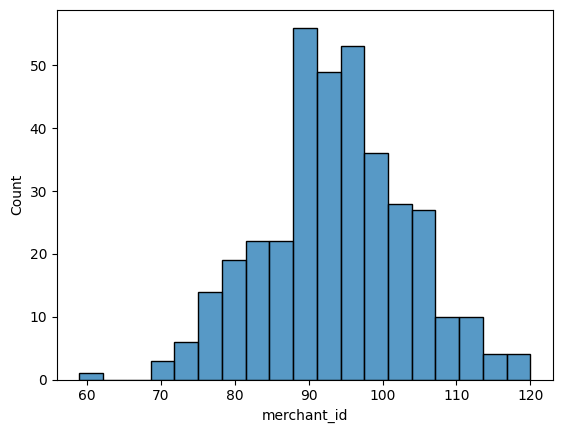

In [377]:
sns.histplot(df.groupby('registration_date').merchant_id.count())

In [378]:
df.groupby('registration_date').merchant_id.count().describe()

count    364.000000
mean      93.700549
std        9.706202
min       59.000000
25%       88.000000
50%       94.000000
75%      100.000000
max      120.000000
Name: merchant_id, dtype: float64

Среднее кол-во регистраций в день ≈ 94.

---

## Дизайн A/B-теста
---

### Определим метрики и гипотезы
---



**метрики успеха и контр метрики:**

- основная метриа - доля активированных фродеров среди всех активированных продавцов
- контр метрика - конверсия в ативацию

Как мы ранее узнали, большинство вродеров являются ИП, поэтому важно, чтобы снижение доли фродеров было преимущественно за счет снижения доли фродеров ИП, поэтому можно выделить прокси метрику:
- прокси метрика - доля активированных фродеров среди всех активированных продавцов в разрезе формы организации бизнеса

**Соответственно определяем гипотезы:**

- для основновной и прокси метрки:


   **H<sub>0</sub> :** внедрение модели определения мошенников на этапе регистрации не изменяет долю активированных фродеров среди всех активированных продавцов

  
    **H<sub>1</sub> :** внедрение модели определения мошенников на этапе регистрации снижает долю активированных фродеров среди всех активированных продавцов

- для контр метрики:

  
    **H<sub>0</sub> :** внедрение модели определения мошенников на этапе регистрации не изменяет конверсию в платящего

  
    **H<sub>1</sub> :** внедрение модели определения мошенников на этапе регистрации снижает конверсию в платящего



In [379]:
#Посчитаем наши метрики:
print("доля фродеров среди активированных продавцов:",  round(activ_df.query('ind_frod == 1').shape[0] / activ_df.shape[0] * 100, 4) )
print("конверсия в активацию:",  round(df['activation_date'].apply(lambda x: 1 if x is not pd.NaT else 0).mean() * 100, 4))

доля фродеров среди активированных продавцов: 8.0774
конверсия в активацию: 58.0409


In [380]:
print("доля фродеров среди активированных продавцов в разрезе формы организации бизнеса: \n", 
      activ_df.query('ind_frod == 1').groupby('type').merchant_id.count() / activ_df.groupby('type').merchant_id.count() * 100)

доля фродеров среди активированных продавцов в разрезе формы организации бизнеса: 
 type
IE     9.553872
LLC    4.277978
Name: merchant_id, dtype: float64


### Выбор теста, определение основных параметров: 
**уровень значимость, мощность, MDE, размер выборки и срок проведения теста**

---

Для проверки стат. значимости изменения основной метрики (доля активированных фродеров среди всех активированных юзеров) можно использовать z-test, так как метрика является пропорцией, а z-test предназначен для работы с долями. 

Можно также использывать и t-test, так как доля фродеров - это среднее от 0 до 1, согласно Центральной предельной теореме при больших выборках распределение средних приближается к нормальному распределению. Только тут нужно учитывать возможность гетероскедастичности (разности дисперсий в двух группах) и лучше использовать t-test Уэлча, если гетероскедастичности не будет, тест отработает также как t-test Стьюдента.

Остановимся на t-test Уэлча, будем использовать его (добавим параметр `equal_var=False`).

---
Уровень значимости (α) = 0.05.

Мощность (1 - β) = 0.8.

Так как мы хотим миинимизировать долю мошенников в активированных юзерах мы можем разбит тест на 2 части:

1. запускаем и ждем когда наберется выборка, которая позволит нам статистически значимо заметить снижение доли фродеров до 5% (MDE = 40% или снижение на 3,31 п.п)

    считаем статистику и делаем выводы

2. ждем когда наберется выбока, которая позволит нам статистически значимо заметить снижение доли фродеров на 25% (MDE = 25% или снижение на 2,1 п.п)ие 

    ститаем статистику делаем выводы


Такой подход позволит нам в случае удачной работы антифрод Ml-модели выявить хорошее снижение доли мошенников (на 40%) за более короткий срок, а если стат значимого результата не будет на для такого MDE, то подождем еще, чтобы задетектить снижение доли мошенников на 25%.

Определим необходимый объем выборки - n и срок проведения

Для оределения n проведем симуляции. Мы хотим понять при какой, как часто мы будем фиксировать стат. значимые различия. Проведем 1000 таких экспериментов, т. е. в цикле 10000 раз проведем t-тест, который будет сравнивать 2 выборки из двух разных распределений (контрольная и тестовая группа).

In [381]:
mu = activ_df.ind_frod.describe()['mean']
sigma = activ_df.ind_frod.describe()['std']
n = 1125
diff = 0.4

n_trials = 10000
significant_count = 0

In [382]:
for i in range(n_trials):
    control_group = np.random.normal(mu, sigma, n)
    exp_group = np.random.normal(mu - mu * diff, sigma, n)
    test_fit = ss.ttest_ind(control_group, exp_group, equal_var=False)
    if test_fit.pvalue < 0.05:
        significant_count += 1
# В каком % случаев наш стат. тест показал стат. значимые различия, т.е. мощность (1 - β) = 
significant_count / n_trials

0.8043

Таким образом при 1125 наблюдений мы сможем задетектить наш MDE = 40%, если взять 1124, мощность теста быдет ниже 80%

Теперь расчитаем n для MDE = 25%

In [383]:
mu = activ_df.ind_frod.describe()['mean']
sigma = activ_df.ind_frod.describe()['std']
n_1 = 2900
diff_1 = 0.25

n_trials = 10000
significant_count_1 = 0

In [384]:
for i in range(n_trials):
    control_group = np.random.normal(mu, sigma, n_1)
    exp_group = np.random.normal(mu - mu * diff_1, sigma, n_1)
    test_fit = ss.ttest_ind(control_group, exp_group, equal_var=False)
    if test_fit.pvalue < 0.05:
        significant_count_1 += 1
# В каком % случаев наш стат. тест показал стат. значимые различия, т.е. мощность (1 - β) = 
significant_count_1 / n_trials

0.8084

Таким образом при 2900 наблюдений мы сможем задетектить наш MDE = 40%

Теперь расчитаем сколько времени нам потребуется для нахождения n и n_1

In [385]:
# посмотрим, сколько у нас продавцов было активировано в разбивке по каждому дню.
activ_df.groupby('registration_date').merchant_id.count().describe()

count    364.000000
mean      54.384615
std        7.489599
min       28.000000
25%       50.000000
50%       54.000000
75%       60.000000
max       74.000000
Name: merchant_id, dtype: float64

В среднем у нас регистрируются и активируются впоследствии ≈ 54 продавца в день (те, кто пройдут полную процедуру регистрации).

In [386]:
print(np.ceil(n*2/54), np.ceil(n_1*2/54), sep='\n')

42.0
108.0


Таким образом для обнаружения MDE=40% нам надо ждать 42 дня, а для обнаружения MDE=25% - 108 дней

### Разбиение на группы и А/А-тест

В рамках A/B-теста мы будем всех продавцов распределять случайным образом делить на две равные группы: тестовую (50%) и контрольную (50%).

На имеющихся исторических данных проведем A/A-тестирование. Таким способом мы:

проверим, насколько наши данные подвержены отклонениям, не связанным с проведением A/B-теста
совершим те же самые действия, которые мы потом будем совершать при проведении настоящего A/B теста
Проведем предварительный набор A/A-тестов с расчетом p-value, которое в случае корректности сплитования и выбора критериев будет распределено равномерно.

Берем activation_df так как для расчета основной метрики нам нужно посчитать долю фродеров среди именно активированных юзеров.

In [334]:
sample_size = 2900
p_values_frod_share = []

for i in range(10000):
    control = activ_df.sample(sample_size)
    test = activ_df.drop(control.index).sample(sample_size)
    result_frod_share = ss.ttest_ind(control.ind_frod, test.ind_frod, equal_var=False)
    pval_frod_share = result_frod_share.pvalue
    p_values_frod_share.append(pval_frod_share)

<Axes: ylabel='Count'>

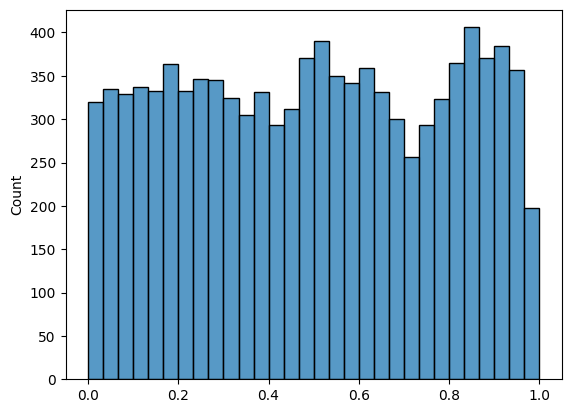

In [335]:
sns.histplot(p_values_frod_share, bins=30)

In [338]:
round(((np.array(p_values_frod_share) <= 0.05).mean()) * 100, 5)

np.float64(4.85)

В t-тесте p-value оказалось меньше либо равно 0.05 в 4.85% случаев. Видно, что вероятность ошибки 1-го рода контролируется.

## 3. Ответы на вопросы

### Как определить, какой продавец мошенник, а какой — нет?

Для определения мошенников можно в процессе регистрации обязать загружать документы и проверять их на подлинность.

Также в процессе регистрации можно обязать привязывать аккаунт в приложении "Мой налог" для ИП. Нужно проверить расчетный счет, он должен принадлежать юр. лицу продавца.

Можно также проверить код ОКВЭД и его соответствие товарам продавца.

Также стоит проверять расчетные счета и ИНН на уникальность, т.е. если продавец с такими ж е данными уже есть в нашей бд, то это возможный мошеннник.

Если говорить об определении активированных мошенников, то тут нужно анализировать действия продавцов. Наприме, если продавец выставляет товар сильно ниже рыночной цены.

### Какие ещё могут быть схемы мошенничества?

- Фрод с фиктивными продажами. Продавец сам заказывает у себя товары, чтобы создать иллюзию доверенного продавца, а затем исчезает с реальными заказами.

- Подмена товара. Отправка дешевого или поддельного товара вместо обещанного.

- Кража личных данных через спам-звонок. Фродер звонит человеку, представляется сотрудником маркетплейса и просит подтвердить данные о доставке, ссылаясь на стандартную процедуру. Этой схемой можно выманить у покупателей логины и пароли от учётных записей.


### Какие продуктовые фичи могут помочь нашим клиентам избежать неприятных ситуаций с мошенничеством?

- Автоматическое предупреждение, если продавец предлагает покупку вне платформы.

- Автоматическое предупреждение, если юзер пытается написать в чат номер телефона.

- Автоматическое предупреждение, настроенное при написании продавцом определенных фраз.
        
- Условное замораживание средств до подтверждения получения товара.

- Фрод-модель с анализом аномального поведения продавцов.

### Через какую механику мошенник узнает контакты покупателя? Что можем сделать, чтобы усложнить жизнь фродерам?


- Через личные сообщения.
    
- Вложенные файлы или изображения с контактными данными.
    
- Использование шаблонных ответов с обходными методами передачи информации.
    
- Встроенные ссылки в описаниях товаров или контакты продавца.


### Как усложнить жизнь мошенникам?

- Фильтрация сообщений и автоматическая замена контактных данных.
    
- Предупреждения покупателям при попытке общения вне платформы.
    
- Анализ описаний товаров на предмет скрытых ссылок.